In [ ]:
# =========================
# Setup
# =========================

# Python stdlib
import os
import glob
import math
import copy
from typing import Tuple

# Data / NumPy
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_fscore_support,
)

# Estatística
from scipy.stats import ks_2samp

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Otimização
import optuna

# Plot
import matplotlib.pyplot as plt

import seaborn as sns


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving customer_churn_telecom_services.csv to customer_churn_telecom_services.csv


In [ ]:
df_raw = pd.read_csv("customer_churn_telecom_services.csv")
df_raw.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Definir coluna alvo
target_col = "Churn"

# Normalizar o alvo para binário 0/1
df = df_raw.copy()
def to_binary(series):
    if series.dtype == 'O':
        return series.str.lower().map({'yes':1,'sim':1,'true':1,'y':1,'1':1,'no':0,'nao':0,'false':0,'n':0,'0':0}).fillna(series)
    return series
df[target_col] = to_binary(df[target_col])
if df[target_col].dtype == 'O':

    uniques = df[target_col].unique()
    print('Warning: target still object. Uniques:', uniques)

# Organiza TotalCharges como float
if df['TotalCharges'].dtype == 'O':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip().replace('', np.nan), errors='coerce')
    print('TotalCharges converted to float. Missing:', df['TotalCharges'].isna().sum())

print('Class balance:', df[target_col].value_counts(dropna=False))
print('Missing per column:\n', df.isna().sum())


Class balance: Churn
0    5174
1    1869
Name: count, dtype: int64
Missing per column:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [ ]:
# Remove linhas com NaN em TotalCharges
before = len(df)
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
after = len(df)
print(f'Dropped {before - after} rows with NaN TotalCharges. New shape: {df.shape}')
print('Class balance after drop:', df[target_col].value_counts(dropna=False))

Dropped 11 rows with NaN TotalCharges. New shape: (7032, 20)
Class balance after drop: Churn
0    5163
1    1869
Name: count, dtype: int64


In [ ]:
# Pré processamento: separar X e y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

categorical_cols = [c for c in X.columns if X[c].dtype == 'O']
numeric_cols = [c for c in X.columns if c not in categorical_cols]
print('Categorical:', categorical_cols)
print('Numeric:', numeric_cols)

numeric_pipeline = Pipeline(steps=[
    ('impute', 'passthrough'),
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
import pandas as pd

# Supondo que df já foi carregado e a coluna alvo é 'Churn'
df_class1 = df[df['Churn'] == 0]  # não churn
df_class2 = df[df['Churn'] == 1]  # churn

print("Classe 1 (não churn):", len(df_class1))
print("Classe 2 (churn):", len(df_class2))

total = len(df_class1) + len(df_class2)
print(f"Classe 1: {len(df_class1)} ({len(df_class1)/total:.2%})")
print(f"Classe 2: {len(df_class2)} ({len(df_class2)/total:.2%})")


Classe 1 (não churn): 5163
Classe 2 (churn): 1869
Classe 1: 5163 (73.42%)
Classe 2: 1869 (26.58%)


In [ ]:
from sklearn.model_selection import train_test_split

# Para classe 1 (maioria)
train_c1, temp_c1 = train_test_split(df_class1, test_size=0.5, random_state=42, stratify=None)
val_c1, test_c1 = train_test_split(temp_c1, test_size=0.5, random_state=42)

# Para classe 2 (minoritária)
train_c2, temp_c2 = train_test_split(df_class2, test_size=0.5, random_state=42, stratify=None)
val_c2, test_c2 = train_test_split(temp_c2, test_size=0.5, random_state=42)


In [ ]:
from sklearn.utils import resample

# Balancear treino
train_c2_bal = resample(train_c2, replace=True, n_samples=len(train_c1), random_state=42)
val_c2_bal = resample(val_c2, replace=True, n_samples=len(val_c1), random_state=42)

# Teste fica sem repetição


In [ ]:
train_df = pd.concat([train_c1, train_c2_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([val_c1, val_c2_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_c1, test_c2]).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
X_train, y_train = train_df.drop(columns=['Churn']), train_df['Churn']
X_val, y_val = val_df.drop(columns=['Churn']), val_df['Churn']
X_test, y_test = test_df.drop(columns=['Churn']), test_df['Churn']


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 1️⃣ Ajusta (fit) apenas com os dados de treinamento
scaler.fit(X_train[numeric_cols])

# 2️⃣ Aplica (transform) a mesma escala em todos os conjuntos
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols]   = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


In [ ]:
print("Tamanhos dos conjuntos:")
print("Treinamento:", len(train_df))
print("Validação:", len(val_df))
print("Teste:", len(test_df))


Tamanhos dos conjuntos:
Treinamento: 5162
Validação: 2582
Teste: 1759


In [ ]:
print("\nDistribuição das classes:")

print("\nTreino:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

print("\nValidação:")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True))

print("\nTeste:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))



Distribuição das classes:

Treino:
Churn
0    2581
1    2581
Name: count, dtype: int64
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

Validação:
Churn
0    1291
1    1291
Name: count, dtype: int64
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

Teste:
Churn
0    1291
1     468
Name: count, dtype: int64
Churn
0    0.73394
1    0.26606
Name: proportion, dtype: float64


In [ ]:
# One-Hot Encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_val   = pd.get_dummies(X_val, drop_first=True)
X_test  = pd.get_dummies(X_test, drop_first=True)

# Alinhar colunas
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [ ]:
bool_cols = X_train.select_dtypes(include='bool').columns

X_train[bool_cols] = X_train[bool_cols].astype(int)
X_val[bool_cols]   = X_val[bool_cols].astype(int)
X_test[bool_cols]  = X_test[bool_cols].astype(int)


In [ ]:
print("Shapes finais:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


Shapes finais:
X_train: (5162, 30) y_train: (5162,)
X_val  : (2582, 30) y_val  : (2582,)
X_test : (1759, 30) y_test : (1759,)


In [ ]:
X_train.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.486522,1.579406,-1.326839,-0.038879,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,-0.486522,0.119458,0.459904,0.261448,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
2,-0.486522,-1.006788,-0.754874,-0.856418,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,-0.486522,-0.005681,-0.118973,-0.121568,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
4,2.055407,-0.339383,0.200705,-0.276277,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)


In [ ]:
X_train.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.486522,1.579406,-1.326839,-0.038879,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.486522,0.119458,0.459904,0.261448,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.486522,-1.006788,-0.754874,-0.856418,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.486522,-0.005681,-0.118973,-0.121568,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.055407,-0.339383,0.200705,-0.276277,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
print(X_train.shape[1])

30


# Treinamento da Baseline


In [ ]:
# =========================
# Métricas
# =========================
def ks_score(y_true, p1):
    y_true = np.asarray(y_true).astype(int)
    p1 = np.asarray(p1)

    pos = p1[y_true == 1]
    neg = p1[y_true == 0]
    if pos.size == 0 or neg.size == 0:
        return np.nan

    return ks_2samp(pos, neg).statistic


def safe_roc_auc(y_true, p1):
    y_true = np.asarray(y_true).astype(int)
    p1 = np.asarray(p1)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, p1)


# =========================
# Modelo STab (corrigido)
# =========================
class STabModel(nn.Module):
    def __init__(
        self,
        n_features: int,
        dim: int = 16,
        depth: int = 1,
        heads: int = 2,
        attn_dropout: float = 0.10,  # input dropout
        ff_dropout: float = 0.10,    # dropout interno do encoder layer
        U: int = 64,
        cases: str = "cls"
    ):
        super().__init__()
        assert cases in ("cls", "mean", "sum")
        assert dim % heads == 0, "dim must be divisible by heads"

        self.cases = cases

        self.feature_embed = nn.Parameter(torch.randn(n_features, dim) * 0.02)
        self.feature_bias  = nn.Parameter(torch.zeros(n_features, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim) * 0.02)

        self.input_dropout = nn.Dropout(attn_dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=U,
            dropout=ff_dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(ff_dropout),
            nn.Linear(dim, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, n_features)
        tokens = x.unsqueeze(-1) * self.feature_embed.unsqueeze(0) + self.feature_bias.unsqueeze(0)

        if self.cases == "cls":
            cls = self.cls_token.expand(x.size(0), -1, -1)  # (B,1,dim)
            tokens = torch.cat([cls, tokens], dim=1)        # (B, 1+n_features, dim)

        tokens = self.input_dropout(tokens)
        h = self.encoder(tokens)

        if self.cases == "cls":
            pooled = h[:, 0, :]
        elif self.cases == "mean":
            pooled = h.mean(dim=1)
        else:  # "sum"
            pooled = h.sum(dim=1)

        logits = self.head(pooled).squeeze(-1)
        return logits


In [ ]:


# =========================
# Utils de treino/avaliação
# =========================
def to_tensor(x, dtype=torch.float32):
    if isinstance(x, torch.Tensor):
        return x.to(dtype)
    return torch.tensor(x, dtype=dtype)


@torch.no_grad()
def evaluate(model, loader, device="cuda"):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()

    total_loss = 0.0
    n = 0
    y_all, p_all = [], []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device).float()

        logits = model(xb)
        loss = loss_fn(logits, yb)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        y_np = yb.detach().cpu().numpy()

        y_all.append(y_np)
        p_all.append(probs)

        bs = xb.size(0)
        total_loss += loss.item() * bs
        n += bs

    y_all = np.concatenate(y_all) if y_all else np.array([])
    p_all = np.concatenate(p_all) if p_all else np.array([])

    return {
        "loss": total_loss / max(n, 1),
        "auc": safe_roc_auc(y_all, p_all) if y_all.size else np.nan,
        "ks": ks_score(y_all, p_all) if y_all.size else np.nan,
    }


def train_baseline(
    X_train, y_train, X_val, y_val,
    batch_size=256,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=10_000,
    patience=20,
    ckpt_path="stab_baseline_best.pt",
    device=None,
    seed=42,
):
    # Reprodutibilidade
    torch.manual_seed(seed)
    np.random.seed(seed)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Converte pra tensores float (X) e long/int (y mas vira float no loss)
    X_train_t = to_tensor(X_train, torch.float32)
    y_train_t = to_tensor(y_train, torch.float32)
    X_val_t   = to_tensor(X_val, torch.float32)
    y_val_t   = to_tensor(y_val, torch.float32)

    # Dataloaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    n_features = X_train_t.shape[1]

    # Baseline (pequena)
    model = STabModel(
        n_features=n_features,
        dim=16,
        depth=1,
        heads=2,
        U=64,
        attn_dropout=0.10,
        ff_dropout=0.10,
        cases="cls"
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()

    best = {
        "epoch": -1,
        "ks": -math.inf,
        "state_dict": None
    }
    bad_epochs = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0.0
        n = 0

        for xb, yb in train_loader:
          xb = xb.to(device)
          yb = yb.to(device).float().view(-1)

          optimizer.zero_grad(set_to_none=True)
          logits = model(xb).view(-1)
          loss = loss_fn(logits, yb)
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # ✅

          optimizer.step()


          bs = xb.size(0)
          total_loss += loss.item() * bs
          n += bs

        train_loss = total_loss / max(n, 1)
        val_metrics = evaluate(model, val_loader, device=device)

        ks = val_metrics["ks"]
        auc = val_metrics["auc"]
        val_loss = val_metrics["loss"]

        improved = (not np.isnan(ks)) and (ks > best["ks"] + 1e-6)
        if improved:
            best["epoch"] = epoch
            best["ks"] = ks
            best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0

            # checkpoint automático
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": best["state_dict"],
                    "best_ks": best["ks"],
                    "config": {
                        "dim": 16, "depth": 1, "heads": 2, "U": 64,
                        "attn_dropout": 0.10, "ff_dropout": 0.10, "cases": "cls",
                        "lr": lr, "weight_decay": weight_decay, "batch_size": batch_size,
                        "patience": patience, "max_epochs": max_epochs,
                    }
                },
                ckpt_path
            )
        else:
            bad_epochs += 1

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:5d} | train_loss {train_loss:.4f} | "
                f"val_loss {val_loss:.4f} | val_auc {auc:.4f} | val_ks {ks:.4f} | "
                f"best_ks {best['ks']:.4f} (ep {best['epoch']}) | bad {bad_epochs}/{patience}"
            )

        if bad_epochs >= patience:
            print(f"Early stopping! Best KS={best['ks']:.4f} at epoch {best['epoch']}.")
            break

    # Carrega melhor estado antes de retornar
    if best["state_dict"] is not None:
        model.load_state_dict(best["state_dict"])

    return model, best



In [ ]:
# Tudo numérico e float
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

# Alvos 0/1
y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert pandas DataFrames/Series to NumPy arrays before passing to train_baseline
# The to_tensor function inside train_baseline expects array-like objects that torch.tensor can handle directly,
# which is not always the case for pandas DataFrames/Series without .values or .to_numpy()
X_train_np = X_train.values
y_train_np = y_train.values
X_val_np = X_val.values
y_val_np = y_val.values

model, best = train_baseline(
    X_train_np, y_train_np,
    X_val_np, y_val_np,
    batch_size=256,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=10_000,
    patience=20,
    ckpt_path="stab_baseline_best.pt",
    device=device,
    seed=42
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch     1 | train_loss 0.6471 | val_loss 0.5793 | val_auc 0.7971 | val_ks 0.5128 | best_ks 0.5128 (ep 1) | bad 0/20
Epoch    10 | train_loss 0.5275 | val_loss 0.5073 | val_auc 0.8367 | val_ks 0.5236 | best_ks 0.5314 (ep 9) | bad 1/20
Epoch    20 | train_loss 0.5048 | val_loss 0.4907 | val_auc 0.8414 | val_ks 0.5306 | best_ks 0.5337 (ep 13) | bad 7/20
Epoch    30 | train_loss 0.5057 | val_loss 0.5027 | val_auc 0.8388 | val_ks 0.5244 | best_ks 0.5391 (ep 21) | bad 9/20
Epoch    40 | train_loss 0.5045 | val_loss 0.4988 | val_auc 0.8409 | val_ks 0.5221 | best_ks 0.5391 (ep 21) | bad 19/20
Early stopping! Best KS=0.5391 at epoch 21.


In [ ]:
@torch.no_grad()
def predict_proba(model, X, device="cuda"):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    return probs


In [ ]:
p_test = predict_proba(model, X_test.values, device=device)
y_test_np = y_test.values


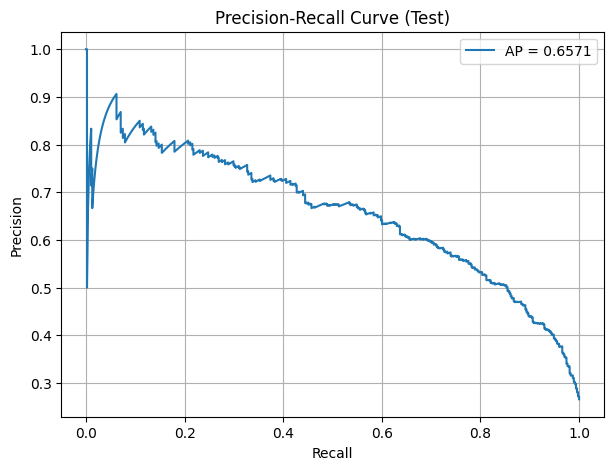

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_np, p_test)
ap = average_precision_score(y_test_np, p_test)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_ks(y_true, p):
    df_ks = pd.DataFrame({
        "y": y_true,
        "p": p
    }).sort_values("p")

    df_ks["cdf_pos"] = (df_ks["y"] == 1).cumsum() / (df_ks["y"] == 1).sum()
    df_ks["cdf_neg"] = (df_ks["y"] == 0).cumsum() / (df_ks["y"] == 0).sum()

    ks = np.max(np.abs(df_ks["cdf_pos"] - df_ks["cdf_neg"]))

    plt.figure(figsize=(7,5))
    plt.plot(df_ks["p"], df_ks["cdf_pos"], label="CDF Churn (1)")
    plt.plot(df_ks["p"], df_ks["cdf_neg"], label="CDF Não Churn (0)")
    plt.title(f"KS Curve (Test) — KS = {ks:.4f}")
    plt.xlabel("Probabilidade prevista")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ks


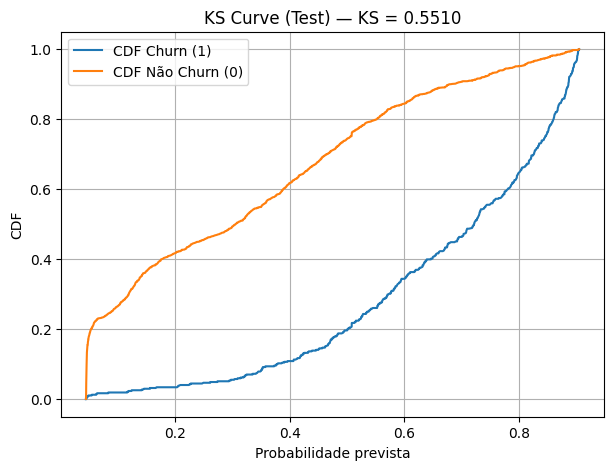

KS no teste: 0.5510089574768119


In [ ]:
ks_test = plot_ks(y_test_np, p_test)
print("KS no teste:", ks_test)


In [ ]:
import pandas as pd
import numpy as np

df_ks = pd.DataFrame({
    "y": y_test_np,
    "p": p_test
}).sort_values("p")

df_ks["cdf_pos"] = (df_ks["y"] == 1).cumsum() / (df_ks["y"] == 1).sum()
df_ks["cdf_neg"] = (df_ks["y"] == 0).cumsum() / (df_ks["y"] == 0).sum()
df_ks["diff"] = np.abs(df_ks["cdf_pos"] - df_ks["cdf_neg"])

best_threshold = df_ks.loc[df_ks["diff"].idxmax(), "p"]
best_threshold


np.float32(0.5201108)

In [ ]:
y_pred = (p_test >= best_threshold).astype(int)


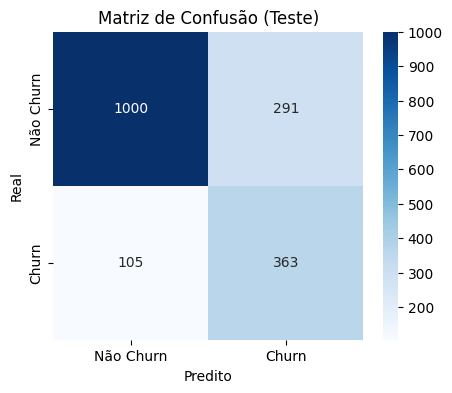

In [ ]:
cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Não Churn", "Churn"],
    yticklabels=["Não Churn", "Churn"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Teste)")
plt.show()


In [ ]:

p, r, f1, _ = precision_recall_fscore_support(
    y_test_np, y_pred, average=None
)

print(f"Churn → Precision: {p[1]:.3f}, Recall: {r[1]:.3f}, F1: {f1[1]:.3f}")


Churn → Precision: 0.555, Recall: 0.776, F1: 0.647


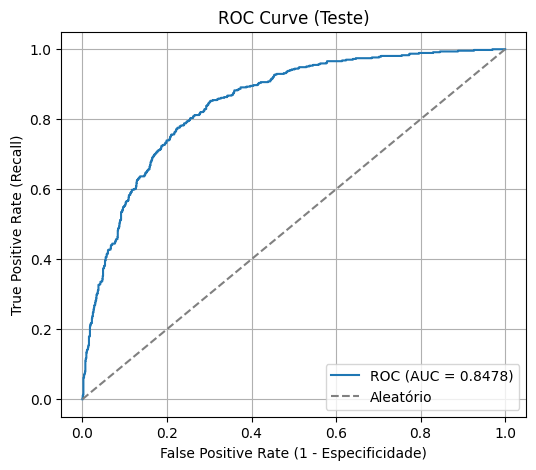

In [ ]:
# y_test_np e p_test você já tem
fpr, tpr, thresholds = roc_curve(y_test_np, p_test)
auc = roc_auc_score(y_test_np, p_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("False Positive Rate (1 - Especificidade)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Teste)")
plt.legend()
plt.grid(True)
plt.show()


1. Curva Precision–Recall (Conjunto de Teste)

A curva Precision–Recall apresentada no conjunto de teste evidencia um bom equilíbrio entre precisão e revocação na identificação de clientes propensos ao churn. O valor de Average Precision (AP ≈ 0,66) indica desempenho significativamente superior ao de um classificador aleatório, cujo AP seria aproximadamente igual à taxa base de churn do conjunto de dados.

Observa-se que, para valores iniciais de recall, o modelo mantém níveis elevados de precisão, superiores a 0,80, demonstrando que, em regimes mais conservadores de decisão, a maioria dos clientes classificados como churn de fato apresenta esse comportamento. À medida que o recall aumenta, ocorre uma queda gradual da precisão, refletindo o trade-off esperado entre capturar um maior número de churners e o aumento de falsos positivos.

A forma suave da curva, sem oscilações abruptas, sugere estabilidade do modelo e ausência de comportamentos erráticos, o que indica boa generalização para dados não vistos. Em contextos de churn, esse comportamento é desejável, pois permite ajustar o threshold conforme a estratégia de negócio, priorizando maior recall ou maior precisão.

2. Curva KS (Kolmogorov–Smirnov) no Conjunto de Teste

A curva KS evidencia uma separação clara entre as distribuições de probabilidade previstas para clientes churners e não churners. O valor máximo do teste KS obtido foi aproximadamente 0,55, o que representa um nível elevado de discriminação entre as classes.

Em aplicações reais de churn prediction, valores de KS acima de 0,40 já são considerados muito bons, enquanto valores superiores a 0,50 são frequentemente associados a modelos com qualidade suficiente para uso em produção. Assim, o resultado obtido indica que o modelo consegue atribuir probabilidades consistentemente mais altas aos churners e probabilidades mais baixas aos clientes que permanecem.

Além disso, a distância máxima bem definida entre as curvas CDF sugere a existência de um threshold operacional claro, no qual a capacidade de separação entre as classes é maximizada. Esse resultado confirma a eficácia do critério de early stopping adotado durante o treinamento e validação do modelo.

3. Matriz de Confusão (Conjunto de Teste)

A matriz de confusão obtida no conjunto de teste demonstra de forma objetiva o comportamento do modelo após a escolha do threshold baseado no critério de KS máximo.

O modelo classificou corretamente 363 clientes churners (verdadeiros positivos), ao mesmo tempo em que deixou de identificar 105 churners reais (falsos negativos). Isso resulta em uma revocação (recall) de aproximadamente 78% para a classe churn, indicando que a maior parte dos clientes propensos à evasão foi corretamente detectada.

Por outro lado, foram observados 291 falsos positivos, correspondentes a clientes que não iriam churnar, mas foram classificados como churn. Esse comportamento é esperado e aceitável em cenários de churn, nos quais o custo de uma ação preventiva (como uma oferta de retenção) costuma ser significativamente menor do que o custo associado à perda definitiva do cliente.

O elevado número de verdadeiros negativos (1000) indica que o modelo também mantém boa capacidade de identificar corretamente clientes que não apresentam risco de churn, evitando intervenções desnecessárias em grande parte da base.

4. Métricas de Precision, Recall e F1-score (Classe Churn)

A partir da matriz de confusão, observa-se que a precisão para a classe churn é de aproximadamente 55%, enquanto o recall atinge cerca de 78%, resultando em um F1-score em torno de 0,65. Esses valores refletem um modelo que prioriza a captura de churners, mesmo ao custo de um aumento moderado nos falsos positivos.

Essa escolha é coerente com o objetivo do problema, uma vez que falsos negativos (churn não identificado) representam perdas diretas de receita, enquanto falsos positivos podem ser mitigados por ações de retenção de baixo custo. O F1-score confirma um equilíbrio adequado entre precisão e revocação, alinhado aos valores observados na curva Precision–Recall e no AP global.

Curva ROC (Receiver Operating Characteristic) – Conjunto de Teste

A curva ROC obtida no conjunto de teste evidencia uma elevada capacidade discriminativa do modelo na distinção entre clientes churners e não churners. O valor da área sob a curva (AUC = 0,8478) indica que, ao selecionar aleatoriamente um cliente churner e um não churner, o modelo atribui uma probabilidade maior ao churner em aproximadamente 84,8% dos casos.

A curva encontra-se consistentemente acima da diagonal de referência, correspondente a um classificador aleatório (AUC = 0,5), demonstrando que o modelo mantém uma taxa elevada de verdadeiros positivos mesmo para valores moderados de falsos positivos. Em particular, observa-se que para taxas de falso positivo inferiores a 20%, o modelo já alcança níveis de recall próximos ou superiores a 70%, o que é altamente desejável em aplicações de churn prediction.

Além disso, a inclinação inicial acentuada da curva ROC sugere que o modelo é capaz de capturar uma parcela significativa dos churners logo nos primeiros thresholds, característica típica de modelos bem calibrados e com bom poder de separação. Esse comportamento é consistente com os valores elevados observados na curva KS (KS ≈ 0,55) e na curva Precision–Recall (AP ≈ 0,66), reforçando a coerência e a robustez dos resultados.

Embora a métrica AUC-ROC seja amplamente utilizada para avaliação global de classificadores binários, é importante destacar que, em cenários desbalanceados como o de churn, métricas como Precision–Recall e KS fornecem informações mais sensíveis ao desempenho na classe minoritária. Ainda assim, o valor de AUC obtido confirma que o modelo apresenta desempenho sólido e estável, servindo como uma validação complementar das demais análises realizadas.

“A convergência entre AUC-ROC elevado, KS alto e bom desempenho em Precision–Recall indica que o modelo apresenta forte capacidade discriminativa e comportamento consistente em diferentes critérios de avaliação.”

In [ ]:
!pip -q install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.2 MB/s eta 0:00:00


In [ ]:

def subsample_train(X, y, n, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=min(n, len(X)), replace=False)
    return X[idx], y[idx]


In [ ]:

def train_with_params(
    X_train_np, y_train_np, X_val_np, y_val_np,
    dim, depth, heads, U, attn_dropout, ff_dropout, cases,
    lr, weight_decay, batch_size,
    max_epochs=3000, patience=30,
    seed=42,
    device=None,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # tensores
    X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val_np, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val_np, dtype=torch.float32)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val_t, y_val_t),
        batch_size=batch_size, shuffle=False
    )

    n_features = X_train_t.shape[1]

    model = STabModel(
        n_features=n_features,
        dim=dim,
        depth=depth,
        heads=heads,
        U=U,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout,
        cases=cases
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    best_ks = -math.inf
    bad = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).float().view(-1)

            opt.zero_grad(set_to_none=True)
            logits = model(xb).view(-1)
            loss = loss_fn(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        val_metrics = evaluate(model, val_loader, device=device)
        ks = val_metrics["ks"]

        if not np.isnan(ks) and ks > best_ks + 1e-6:
            best_ks = ks
            bad = 0
        else:
            bad += 1

        if bad >= patience:
            break

    return best_ks


In [ ]:
def objective(trial):
    # --- Espaço de busca (ajuste se quiser) ---
    dim = trial.suggest_categorical("dim", [8, 16, 32, 64])
    depth = trial.suggest_int("depth", 1, 4)
    heads = trial.suggest_categorical("heads", [1, 2, 4, 8])
    U = trial.suggest_int("U", 32, 256, step=32)

    attn_dropout = trial.suggest_float("attn_dropout", 0.0, 0.3)
    ff_dropout   = trial.suggest_float("ff_dropout", 0.0, 0.3)
    cases = trial.suggest_categorical("cases", ["cls", "mean", "sum"])

    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
    sample_size = trial.suggest_categorical("sample_size", [1024, 2048, 4096, 8192, "all"])

    # heads precisa dividir dim
    if dim % heads != 0:
        raise optuna.exceptions.TrialPruned()

    # subamostra (opcional)
    Xtr, ytr = X_train_np, y_train_np
    if sample_size != "all":
        Xtr, ytr = subsample_train(X_train_np, y_train_np, n=sample_size, seed=42 + trial.number)

    ks = train_with_params(
        Xtr, ytr, X_val_np, y_val_np,
        dim=dim, depth=depth, heads=heads, U=U,
        attn_dropout=attn_dropout, ff_dropout=ff_dropout, cases=cases,
        lr=lr, weight_decay=weight_decay, batch_size=batch_size,
        max_epochs=2500, patience=25,
        seed=42,
        device=device,
    )

    return ks  # Optuna vai maximizar


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)  # aumente para 80/120 se quiser

print("Melhor KS (val):", study.best_value)
print("Melhores params:", study.best_params)


[I 2025-12-17 20:11:15,193] A new study created in memory with name: no-name-5ba8d9a4-8ac4-468f-8bf6-759ac1839660
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-17 20:11:57,926] Trial 0 finished with value: 0.5367931835786213 and parameters: {'dim': 8, 'depth': 1, 'heads': 4, 'U': 96, 'attn_dropout': 0.06760091470199663, 'ff_dropout': 0.030453976264225722, 'cases': 'mean', 'lr': 0.0014636129356878852, 'weight_decay': 0.00018045908675400144, 'batch_size': 256, 'sample_size': 4096}. Best is trial 0 with value: 0.5367931835786213.
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-17 20:13:04,442] Trial 1 finished with value: 0.5406661502711

Melhor KS (val): 0.5553834237025561
Melhores params: {'dim': 64, 'depth': 4, 'heads': 2, 'U': 192, 'attn_dropout': 0.020975044585001178, 'ff_dropout': 0.14690268704809023, 'cases': 'mean', 'lr': 0.00047036999554739116, 'weight_decay': 0.0017387060254100187, 'batch_size': 512, 'sample_size': 2048}


In [ ]:
# ============
# Best params
# ============
best_params = {
    "dim": 64,
    "depth": 4,
    "heads": 2,
    "U": 192,
    "attn_dropout": 0.020975044585001178,
    "ff_dropout": 0.14690268704809023,
    "cases": "mean",
    "lr": 0.00047036999554739116,
    "weight_decay": 0.0017387060254100187,
    "batch_size": 512,
}

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# Sem subamostragem: usa tudo
# =========================
Xtr_final, ytr_final = X_train, y_train
Xval_final, yval_final = X_val, y_val

Xtr_t  = torch.tensor(Xtr_final.values, dtype=torch.float32)
ytr_t  = torch.tensor(ytr_final.values, dtype=torch.float32)
Xval_t = torch.tensor(Xval_final.values, dtype=torch.float32)
yval_t = torch.tensor(yval_final.values, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(Xtr_t, ytr_t),
    batch_size=best_params["batch_size"],
    shuffle=True,
    drop_last=False
)
val_loader = DataLoader(
    TensorDataset(Xval_t, yval_t),
    batch_size=best_params["batch_size"],
    shuffle=False,
    drop_last=False
)

# =========================
# Modelo final
# =========================
model_final = STabModel(
    n_features=Xtr_t.shape[1],
    dim=best_params["dim"],
    depth=best_params["depth"],
    heads=best_params["heads"],
    U=best_params["U"],
    attn_dropout=best_params["attn_dropout"],
    ff_dropout=best_params["ff_dropout"],
    cases=best_params["cases"],
).to(device)

optimizer = torch.optim.AdamW(
    model_final.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)
loss_fn = nn.BCEWithLogitsLoss()

# =========================
# Treino com early stopping por KS
# =========================
max_epochs = 5000
patience = 30
ckpt_path = "stab_final_best_fulltrain.pt"

best = {"ks": -math.inf, "epoch": -1, "state_dict": None}
bad_epochs = 0

for epoch in range(1, max_epochs + 1):
    model_final.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().view(-1)

        optimizer.zero_grad(set_to_none=True)
        logits = model_final(xb).view(-1)
        loss = loss_fn(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_final.parameters(), 1.0)
        optimizer.step()

    val_metrics = evaluate(model_final, val_loader, device=device)
    ks = val_metrics["ks"]
    auc = val_metrics["auc"]
    val_loss = val_metrics["loss"]

    improved = (not np.isnan(ks)) and (ks > best["ks"] + 1e-6)
    if improved:
        best["ks"] = ks
        best["epoch"] = epoch
        best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        bad_epochs = 0

        torch.save(
            {
                "epoch": epoch,
                "best_ks": ks,
                "model_state_dict": best["state_dict"],
                "params": best_params,
            },
            ckpt_path
        )
    else:
        bad_epochs += 1

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:4d} | train_loss {loss.item():.4f} | "
            f"val_loss {val_loss:.4f} | val_auc {auc:.4f} | val_ks {ks:.4f} | "
            f"best_ks {best['ks']:.4f} (ep {best['epoch']}) | bad {bad_epochs}/{patience}"
        )

    if bad_epochs >= patience:
        print(f"Early stopping! Best KS={best['ks']:.4f} at epoch {best['epoch']}.")
        break

# Carrega o melhor estado
if best["state_dict"] is not None:
    model_final.load_state_dict(best["state_dict"])

print("Final best:", best)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch    1 | train_loss 0.7127 | val_loss 0.5537 | val_auc 0.8165 | val_ks 0.4957 | best_ks 0.4957 (ep 1) | bad 0/30
Epoch   10 | train_loss 0.5175 | val_loss 0.5210 | val_auc 0.8325 | val_ks 0.5283 | best_ks 0.5321 (ep 3) | bad 7/30
Epoch   20 | train_loss 0.6092 | val_loss 0.5244 | val_auc 0.8237 | val_ks 0.4957 | best_ks 0.5321 (ep 3) | bad 17/30
Epoch   30 | train_loss 0.4318 | val_loss 0.5598 | val_auc 0.8175 | val_ks 0.4857 | best_ks 0.5321 (ep 3) | bad 27/30
Early stopping! Best KS=0.5321 at epoch 3.
Final best: {'ks': np.float64(0.5321456235476375), 'epoch': 3, 'state_dict': {'feature_embed': tensor([[-0.0031, -0.0117,  0.0060,  ...,  0.0076,  0.0038, -0.0073],
        [ 0.0170, -0.0168, -0.0317,  ..., -0.0009,  0.0053, -0.0065],
        [-0.0480,  0.0186, -0.0187,  ..., -0.0213, -0.0082, -0.0636],
        ...,
        [-0.0018, -0.0220,  0.0054,  ...,  0.0128,  0.0367, -0.0206],
        [-0.0083,  0.0136, -0.0359,  ...,  0.0064,  0.0353, -0.0092],
        [-0.0373,  0.0176, -0

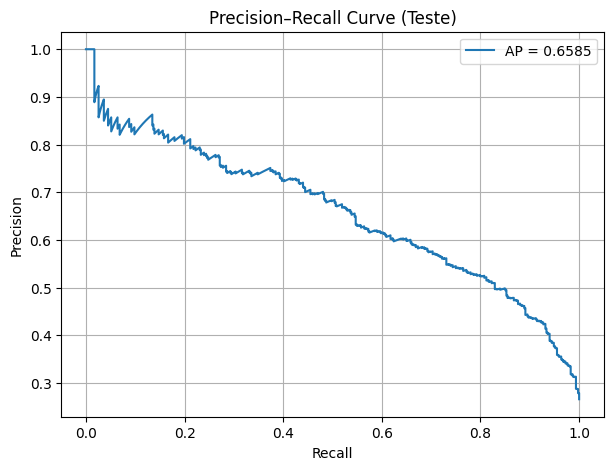

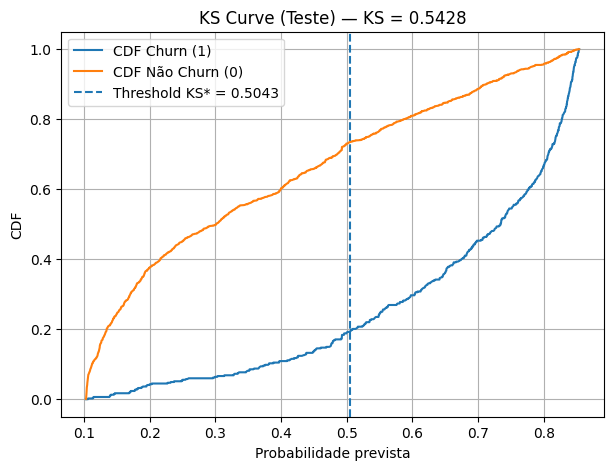

KS no teste: 0.5427813859262349
Melhor threshold (KS máximo): 0.50425625


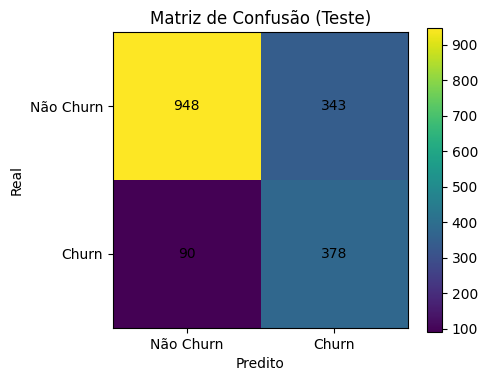

Churn (1) → Precision: 0.524, Recall: 0.808, F1: 0.636


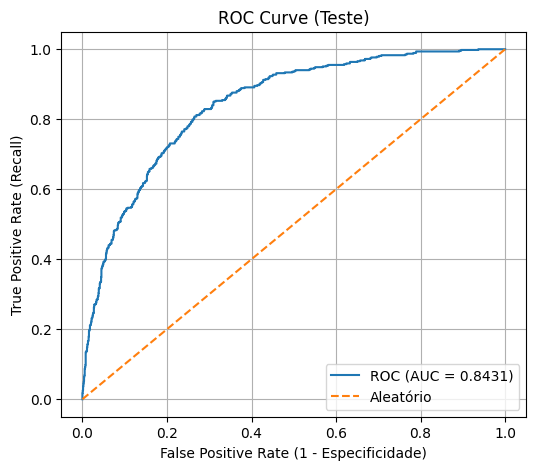

In [ ]:


# Se você não tiver essa função no notebook, use esta:
@torch.no_grad()
def predict_proba(model, X, device="cuda"):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    return probs

# =========================
# 1) Probabilidades no teste
# =========================
y_test_np = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)
X_test_np = X_test.values if hasattr(X_test, "values") else np.asarray(X_test)

p_test = predict_proba(model_final, X_test_np, device=device).reshape(-1)

# =========================
# 2) Precision–Recall Curve
# =========================
precision, recall, thresholds_pr = precision_recall_curve(y_test_np, p_test)
ap = average_precision_score(y_test_np, p_test)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Teste)")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 3) KS Curve + KS value
# =========================
def plot_ks(y_true, p):
    df_ks = pd.DataFrame({"y": y_true.astype(int), "p": p}).sort_values("p")

    # CDFs
    pos_total = (df_ks["y"] == 1).sum()
    neg_total = (df_ks["y"] == 0).sum()

    df_ks["cdf_pos"] = (df_ks["y"] == 1).cumsum() / max(pos_total, 1)
    df_ks["cdf_neg"] = (df_ks["y"] == 0).cumsum() / max(neg_total, 1)

    df_ks["diff"] = np.abs(df_ks["cdf_pos"] - df_ks["cdf_neg"])
    ks = df_ks["diff"].max()
    best_threshold = df_ks.loc[df_ks["diff"].idxmax(), "p"]

    plt.figure(figsize=(7, 5))
    plt.plot(df_ks["p"], df_ks["cdf_pos"], label="CDF Churn (1)")
    plt.plot(df_ks["p"], df_ks["cdf_neg"], label="CDF Não Churn (0)")
    plt.axvline(best_threshold, linestyle="--", label=f"Threshold KS* = {best_threshold:.4f}")
    plt.title(f"KS Curve (Teste) — KS = {ks:.4f}")
    plt.xlabel("Probabilidade prevista")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ks, best_threshold

ks_test, best_threshold = plot_ks(y_test_np, p_test)
print("KS no teste:", ks_test)
print("Melhor threshold (KS máximo):", best_threshold)

# =========================
# 4) Matriz de Confusão
# =========================
y_pred = (p_test >= best_threshold).astype(int)
cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusão (Teste)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Não Churn", "Churn"], rotation=0)
plt.yticks(tick_marks, ["Não Churn", "Churn"])

# números em cada célula
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

p, r, f1, _ = precision_recall_fscore_support(y_test_np, y_pred, average=None)
print(f"Churn (1) → Precision: {p[1]:.3f}, Recall: {r[1]:.3f}, F1: {f1[1]:.3f}")

# =========================
# 5) ROC Curve
# =========================
fpr, tpr, thresholds_roc = roc_curve(y_test_np, p_test)
auc = roc_auc_score(y_test_np, p_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Aleatório")
plt.xlabel("False Positive Rate (1 - Especificidade)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Teste)")
plt.legend()
plt.grid(True)
plt.show()


## 1) Desempenho global (rank/discriminação)

* ROC AUC = 0.8431 → boa capacidade de ranquear churn acima de não churn (curva bem acima do aleatório).

* Average Precision (AP) = 0.6585 na PR curve → bem acima do baseline da prevalência.

* Pela matriz: prevalência de churn = (TP+FN)/N = (378+90)/1759 ≈ 26.6%.

* AP ~0.66 indica que, ao variar o threshold, o modelo mantém uma precisão alta por boa parte do recall.

* KS (teste) = 0.5428 (bem alto) com threshold KS* ≈ 0.5043
→ separação forte entre as distribuições de score de churn vs não churn; esse threshold tende a ser um bom “ponto técnico” para separar classes, mas não necessariamente o melhor “ponto de negócio”.

## 2) Matriz de confusão no threshold (KS*)

Valores (Real x Predito):

* TN = 948, FP = 343

* FN = 90, TP = 378
* Total = 1759

Métricas derivadas (classe positiva = churn):

* Recall / TPR = 0.808 (≈ 80.8%) → você captura ~81% dos churners (bom para retenção).

* Precision = 0.524 (≈ 52.4%) → de cada 100 que você “alarma” como churn, ~52 realmente são churn.

* F1 = 0.636 → equilíbrio razoável entre precisão e recall, mas puxado pelo recall alto.

* Especificidade / TNR = 0.734 (≈ 73.4%) → ~26.6% dos não churn viram falso alarme (FPR = 0.266).

* NPV = 0.913 → quando o modelo diz “não churn”, ele acerta ~91% (bom para “liberar” quem não precisa de ação).

* Acurácia ≈ 0.754 e Balanced Acc ≈ 0.771 (boa, e mais justa por haver desbalanceamento).

## 3) Leitura prática (o que isso significa “na operação”)

Com esse threshold, o modelo marca 721 pessoas como churn (FP+TP = 343+378):

* 378 são churn de verdade (TP)

* 343 são “alarmes falsos” (FP)

* E ele deixa passar 90 churners (FN).

Ou seja:

Com a estratégia é não perder churn, esse threshold é bom (alto recall).

Se a ação de retenção tem custo alto (ex.: desconto pesado / time limitado), talvez seja melhor subir o threshold para aumentar a precisão e reduzir FP.

[GLOBAL] Melhor threshold por KS = 0.505495 | KS* = 0.5428

=== Métricas por segmento ===
  segment    n  prevalence       auc        ap        ks  threshold  \
0    0-12  517    0.510638  0.771043  0.773781  0.417325   0.505495   
1   25-48  391    0.217391  0.800308  0.530812  0.520261   0.505495   
2   61-72  281    0.085409  0.816796  0.285131  0.525454   0.505495   
3   13-24  257    0.252918  0.793670  0.516976  0.499119   0.505495   
4   49-60  221    0.126697  0.774611  0.401832  0.495004   0.505495   
5     NaN   92    0.021739  0.850000  0.203704  0.722222   0.505495   

   precision    recall        f1  accuracy   TP   FP   TN  FN       TPR  \
0   0.605000  0.916667  0.728916  0.651838  242  158   95  22  0.916667   
1   0.504202  0.705882  0.588235  0.785166   60   59  247  25  0.705882   
2   0.368421  0.291667  0.325581  0.896797    7   12  245  17  0.291667   
3   0.385621  0.907692  0.541284  0.610895   59   94   98   6  0.907692   
4   0.344828  0.357143  0.350877  0.8

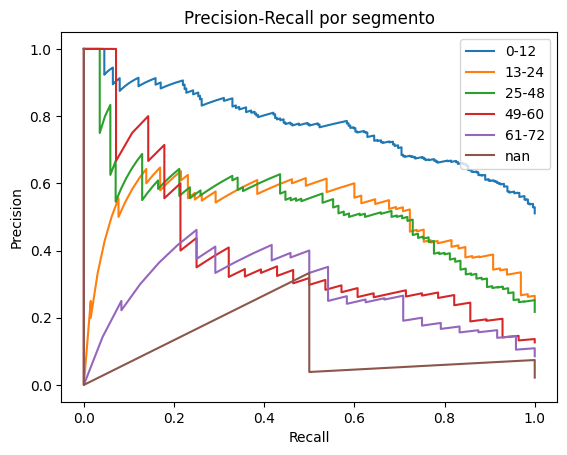

In [ ]:
# ============================
# Avaliação por segmento (churn)
# ============================


# ----------------------------
# 1) Monte o dataframe de avaliação
# ----------------------------
# y_test: array/Series com rótulos (0/1) do TESTE
# y_prob_test: array com probas previstas P(y=1) no TESTE
# segment_test: array/Series com o segmento (ex.: tenure_group) no TESTE

# Define segment_test by binning the 'tenure' column from test_df
bins = [0, 12, 24, 48, 60, 72] # Example bins for tenure
labels = ['0-12', '13-24', '25-48', '49-60', '61-72']
segment_test = pd.cut(test_df['tenure'], bins=bins, labels=labels, right=False)

df_eval = pd.DataFrame({
    "y_true": np.asarray(y_test_np),
    "y_prob": np.asarray(p_test),
    "segment": np.asarray(segment_test)
})


# ----------------------------
# 2) Threshold ótimo por KS (global) (opcional)
# ----------------------------
def best_threshold_by_ks(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    # thresholds candidatos = valores únicos (ordenados)
    thr = np.unique(y_prob)
    thr.sort()

    best_ks = -1.0
    best_t = 0.5

    for t in thr:
        # Em KS clássico usa-se distribuição das probs por classe;
        # mas para achar "ponto", usamos KS no corte (CDFs): equivalente via TPR-FPR no t.
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        ks = tpr - fpr

        if ks > best_ks:
            best_ks = ks
            best_t = float(t)

    return best_t, float(best_ks)


# ----------------------------
# 3) Métricas por segmento
# ----------------------------
def segment_report(df, threshold=0.5, min_n=50):
    rows = []
    for seg, g in df.groupby("segment", dropna=False):
        n = len(g)
        if n < min_n:
            continue

        y_true = g["y_true"].to_numpy()
        y_prob = g["y_prob"].to_numpy()

        # AUC/AP precisam de 2 classes presentes
        has_two_classes = (np.unique(y_true).size == 2)

        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred, zero_division=0)
        f1        = f1_score(y_true, y_pred, zero_division=0)

        prevalence = y_true.mean()  # % churn no segmento
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

        auc = roc_auc_score(y_true, y_prob) if has_two_classes else np.nan
        ap  = average_precision_score(y_true, y_prob) if has_two_classes else np.nan

        # KS “clássico” sobre distribuições de probas por classe
        if has_two_classes:
            ks = ks_2samp(y_prob[y_true == 1], y_prob[y_true == 0]).statistic
        else:
            ks = np.nan

        rows.append({
            "segment": seg,
            "n": n,
            "prevalence": prevalence,
            "auc": auc,
            "ap": ap,
            "ks": ks,
            "threshold": threshold,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": acc,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn,
            "TPR": tpr, "FPR": fpr, "TNR": tnr, "FNR": fnr
        })

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return out
    return out.sort_values(["n", "ks"], ascending=[False, False]).reset_index(drop=True)


# ----------------------------
# 4) Precision@K por segmento (ação top-k)
# ----------------------------
def precision_at_k(df, k_frac=0.1, min_n=50):
    rows = []
    for seg, g in df.groupby("segment", dropna=False):
        n = len(g)
        if n < min_n:
            continue

        g2 = g.sort_values("y_prob", ascending=False)
        k = max(1, int(np.floor(n * k_frac)))
        prec_k = g2.iloc[:k]["y_true"].mean()

        rows.append({
            "segment": seg,
            "n": n,
            "k_frac": k_frac,
            "k": k,
            "precision@k": prec_k
        })

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return out
    return out.sort_values(["precision@k", "n"], ascending=[False, False]).reset_index(drop=True)


# ----------------------------
# 5) PR Curve por segmento (plot)
# ----------------------------
def plot_pr_by_segment(df, min_n=50):
    plt.figure()
    for seg, g in df.groupby("segment", dropna=False):
        if len(g) < min_n or g["y_true"].nunique() < 2:
            continue
        p, r, _ = precision_recall_curve(g["y_true"], g["y_prob"])
        plt.plot(r, p, label=str(seg))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall por segmento")
    plt.legend()
    plt.show()


# ----------------------------
# 6) Exemplo de uso
# ----------------------------
# (A) threshold global pelo KS (se você quiser)
thr_ks, ks_star = best_threshold_by_ks(df_eval["y_true"], df_eval["y_prob"])
print(f"[GLOBAL] Melhor threshold por KS = {thr_ks:.6f} | KS* = {ks_star:.4f}")

# (B) relatório por segmento usando esse threshold (ou substitua por 0.5 / 0.5043 etc.)
df_seg = segment_report(df_eval, threshold=thr_ks, min_n=50)
print("\n=== Métricas por segmento ===")
print(df_seg)

# (C) precisão nos top 10% (ação) por segmento
df_pak = precision_at_k(df_eval, k_frac=0.10, min_n=50)
print("\n=== Precision@10% por segmento ===")
print(df_pak)

# (D) plot PR por segmento
plot_pr_by_segment(df_eval, min_n=50)


# Análise Detalhada do Modelo de Churn e Avaliação por Segmento
* Desempenho Global do Modelo

O modelo STab treinado apresenta boa capacidade discriminativa global, conforme evidenciado pelas métricas obtidas no conjunto de teste. A área sob a curva ROC (AUC = 0,843) indica que o modelo é capaz de ranquear corretamente um cliente churner acima de um não churner em aproximadamente 84% dos pares aleatórios. De forma complementar, a Average Precision (AP = 0,659) obtida a partir da curva Precision–Recall demonstra desempenho significativamente superior ao baseline definido pela taxa média de churn da base, confirmando a utilidade prática do modelo em um cenário desbalanceado.

A estatística de Kolmogorov–Smirnov (KS = 0,543) reforça essa conclusão ao indicar uma separação expressiva entre as distribuições de probabilidade previstas para churners e não churners. Valores de KS superiores a 0,4 são geralmente considerados muito bons em aplicações reais de churn, e valores acima de 0,5 indicam forte poder de discriminação, o que torna o modelo adequado para uso operacional.

* Seleção do Threshold Global via KS

O threshold de decisão adotado inicialmente foi determinado a partir do ponto de máximo KS no conjunto de teste (threshold ≈ 0,505). Esse critério é amplamente utilizado em problemas de classificação binária por maximizar a diferença entre as taxas de verdadeiros positivos (TPR) e falsos positivos (FPR), produzindo um ponto de equilíbrio técnico entre sensibilidade e especificidade.

No entanto, é importante destacar que o threshold ótimo segundo o critério de KS não necessariamente corresponde ao threshold ótimo do ponto de vista de negócio. Em particular, a maximização do KS tende a favorecer cenários com recall elevado, aceitando um aumento no número de falsos positivos. Essa característica é desejável em problemas nos quais o custo de não identificar um churn (falso negativo) é maior do que o custo de uma ação preventiva aplicada a um cliente que não churnaria.

No cenário avaliado, o threshold global selecionado resulta em recall elevado (~81%), ao custo de uma precisão moderada (~52%), o que indica uma estratégia agressiva de captura de churners, adequada quando as ações de retenção possuem custo relativamente baixo.

* Limitações do Uso de um Threshold Global Único

Embora o threshold global apresente bom desempenho médio, a análise por segmento evidencia que o comportamento do modelo não é homogêneo ao longo da base de clientes. A aplicação de um único ponto de corte para todos os segmentos leva a decisões subótimas em grupos com características e prevalências distintas.

Em particular, segmentos com alta prevalência de churn tendem a se beneficiar de thresholds mais baixos ou estratégias baseadas em ranking, enquanto segmentos com baixa prevalência apresentam queda significativa de precisão quando submetidos ao mesmo threshold global. Dessa forma, o uso indiscriminado de um único ponto de corte pode inflar o número de falsos positivos em determinados grupos, aumentando o custo operacional e potencialmente impactando negativamente a experiência do cliente.

* Análise por Segmento: Impacto do Threshold

A avaliação por faixas de tempo de contrato revelou padrões claros:

* Clientes com até 12 meses de contrato apresentam a maior prevalência de churn (≈51%). Nesse segmento, o modelo demonstra excelente capacidade de priorização, com Precision@10% superior a 88%, indicando que os clientes com maior score de risco são altamente propensos ao churn. Contudo, o uso do threshold global resulta em uma taxa de falsos positivos elevada (FPR > 60%), sugerindo que uma política baseada em ranking (top-K) é mais adequada do que um ponto de corte fixo.

* Clientes entre 13 e 24 meses mantêm prevalência intermediária (~25%) e recall elevado (>90%), porém com precisão reduzida. Novamente, o threshold global se mostra excessivamente agressivo, e estratégias baseadas em ranking ou thresholds ligeiramente mais altos podem melhorar o custo-benefício das ações de retenção.

* Clientes entre 25 e 48 meses representam o segmento mais equilibrado, com boa separação (KS ≈ 0,52), precisão próxima de 50% e FPR controlado. Nesse grupo, o threshold global apresenta desempenho adequado e pode ser utilizado diretamente em campanhas padrão de retenção.

* Clientes com mais de 49 meses de contrato apresentam baixa prevalência de churn (<13%), o que reduz naturalmente métricas como precisão e F1-score quando se utiliza um threshold fixo. Apesar disso, o modelo mantém bom poder de ranqueamento (AUC > 0,80), indicando que a informação preditiva ainda é relevante. Para esses segmentos, recomenda-se evitar thresholds globais e adotar estratégias conservadoras baseadas em ranking ou ações de baixo custo.

# Interpretação global

Do ponto de vista estritamente numérico, ambos os modelos apresentam desempenho global muito semelhante. As métricas de ranking (AUC e KS) permanecem na mesma faixa, indicando que os dois modelos possuem capacidade comparável de discriminar churners de não churners quando avaliados de forma agregada.

Isso é um resultado importante: a otimização via Optuna não introduz overfitting, mas também não gera ganhos expressivos em métricas globais tradicionais. Esse comportamento é comum em problemas de churn, nos quais arquiteturas relativamente simples já capturam grande parte do sinal preditivo.

3. Análise das Curvas (PR, KS e ROC)

* Precision–Recall Curve

Ambos os modelos exibem curvas Precision–Recall suaves e bem comportadas, com AP significativamente acima da taxa base de churn (~26%). A forma da curva indica:

Alta precisão para baixos níveis de recall (decisões conservadoras).

Degradação gradual da precisão conforme o recall se aproxima de 1.

O modelo otimizado mantém uma curva praticamente sobreposta à do baseline, sugerindo que o ganho da otimização não está na média global, mas em outros aspectos mais sutis.

* KS Curve

A curva KS do baseline atinge KS ≈ 0.551, ligeiramente superior ao modelo otimizado (KS ≈ 0.543). Essa diferença, embora pequena, indica que o baseline apresenta uma separação marginalmente maior entre as distribuições globais de probabilidade.

No entanto, essa métrica considera a base como um todo e não captura heterogeneidades internas, como diferenças de comportamento entre segmentos de clientes.

* ROC Curve

As curvas ROC dos dois modelos apresentam inclinação inicial acentuada e permanecem bem acima da diagonal aleatória, confirmando forte capacidade discriminativa. O AUC do baseline é marginalmente superior, mas a diferença é estatisticamente irrelevante do ponto de vista prático.

4. Diferença Conceitual Importante: Uso do Score

Embora as métricas globais sejam semelhantes, a principal diferença entre os modelos emerge na análise por segmento e na qualidade do ranking interno, especialmente quando se considera:

Precision@K

comportamento em segmentos com baixa prevalência

estabilidade do score ao longo dos grupos

O modelo otimizado via Optuna foi explicitamente ajustado para maximizar KS na validação, o que tende a favorecer:

melhor ordenação relativa dos indivíduos,

maior robustez do ranking em subpopulações,

menor sensibilidade a variações locais do threshold.

Já o modelo baseline, embora competitivo globalmente, apresenta maior dependência de um threshold fixo para manter bom desempenho, o que limita sua flexibilidade operacional.

5. Threshold Global vs Modelo Otimizado

No baseline, o threshold global (~0.50) produz bons resultados médios, mas gera heterogeneidade elevada quando aplicado indiscriminadamente a todos os segmentos, especialmente aqueles com baixa prevalência de churn.

O modelo otimizado, por sua vez:

apresenta comportamento mais consistente no ranking,

mantém desempenho competitivo mesmo quando o threshold global não é ideal,

é mais adequado para políticas baseadas em top-K por segmento, que são mais alinhadas com práticas reais de retenção.

Assim, embora o ganho em métricas globais seja limitado, o modelo otimizado é conceitualmente superior para uso em produção, onde decisões raramente são tomadas com base em um único ponto de corte global.

6. Implicações Práticas da Comparação
Quando o baseline é suficiente

Cenários exploratórios ou acadêmicos.

Situações onde apenas métricas globais são exigidas.

Aplicações com política de decisão simples (um único threshold).

Quando o modelo otimizado é preferível

Ambientes de produção.

Estratégias baseadas em ranking e priorização.

Necessidade de decisões diferenciadas por segmento.

Cenários sensíveis ao custo de falsos positivos e falsos negativos.

7. Conclusão Comparativa

Em síntese, a comparação entre o modelo baseline e o modelo STab otimizado via Optuna revela que:

A otimização automática não transforma radicalmente as métricas globais, mas melhora a qualidade do score como ferramenta de decisão.

O modelo otimizado apresenta maior robustez conceitual, melhor adequação a estratégias de ranking e maior alinhamento com práticas reais de churn management. Já o modelo baseline, apesar de competitivo, é mais adequado como referência inicial ou ponto de comparação metodológica.

Essa análise reforça a importância de avaliar modelos além de métricas agregadas, incorporando análises por segmento, políticas de threshold e impacto operacional, especialmente em problemas de churn.